In [9]:
import numpy as np 
import pandas as pd

import sys
sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess
import gensim, spacy

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
data = pd.read_csv(r'C:\Users\49173\Desktop\tripadvisor_hotel_reviews.csv', encoding='utf-8')
data.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [11]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


In [12]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

In [13]:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [14]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [15]:
tokens_reviews = list(sent_to_words(data['review_list']))

In [16]:
tokens_reviews = make_n_grams(tokens_reviews)

In [17]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
! python -m spacy download en_core_web_sm

  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
  Running setup.py install for en-core-web-sm: started
    Running setup.py install for en-core-web-sm: finished with status 'done'
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [19]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [20]:
np.random.seed(0)

In [21]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 15930 clusters with 6 clusters populated
In stage 1: transferred 9141 clusters with 6 clusters populated
In stage 2: transferred 5895 clusters with 6 clusters populated
In stage 3: transferred 4938 clusters with 6 clusters populated
In stage 4: transferred 4261 clusters with 6 clusters populated
In stage 5: transferred 3761 clusters with 6 clusters populated
In stage 6: transferred 3374 clusters with 6 clusters populated
In stage 7: transferred 3250 clusters with 6 clusters populated
In stage 8: transferred 3215 clusters with 6 clusters populated
In stage 9: transferred 3115 clusters with 6 clusters populated
In stage 10: transferred 3058 clusters with 6 clusters populated
In stage 11: transferred 3008 clusters with 6 clusters populated
In stage 12: transferred 2864 clusters with 6 clusters populated
In stage 13: transferred 2852 clusters with 6 clusters populated
In stage 14: transferred 2750 clusters with 6 clusters populated
In stage 15: transferred 2795 clus

In [22]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [23]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [1397 1182 2409 6466 2994 6043]

Most important clusters (by number of docs inside): [3 5 4 2 0 1]

Cluster 3 : [('night', 4244), ('breakfast', 2972), ('bed', 2877), ('bathroom', 2385), ('walk', 2309), ('area', 1980), ('price', 1965), ('restaurant', 1965), ('floor', 1934), ('view', 1865)]

Cluster 5 : [('resort', 7578), ('food', 7047), ('pool', 6073), ('beach', 5467), ('restaurant', 5237), ('night', 5221), ('people', 4935), ('want', 3755), ('drink', 3499), ('bar', 3422)]

Cluster 4 : [('breakfast', 1717), ('night', 1704), ('walk', 1474), ('restaurant', 1112), ('view', 972), ('area', 967), ('bar', 863), ('bathroom', 805), ('bed', 747), ('city', 725)]

Cluster 2 : [('breakfast', 1250), ('walk', 1122), ('night', 1012), ('restaurant', 805), ('florence', 602), ('recommend', 549), ('bathroom', 518), ('area', 510), ('love', 480), ('city', 474)]

Cluster 0 : [('night', 541), ('love', 370), ('restaurant', 370), ('return', 364), ('breakfast', 363), ('view', 348), 

In [24]:
# I don`t rename the clusters

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [25]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [26]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

Text   Topic Rating  \
0  nice hotel expensive parking got good deal sta...  type 1      4   
1  ok nothing special charge diamond member hilto...   Other      2   
2  nice rooms not 4* experience hotel monaco seat...  type 1      3   
3  unique, great stay, wonderful time hotel monac...  type 1      5   
4  great stay great stay, went seahawk game aweso...  type 2      5   

                                          Lemma-text  
0  [parking, deal, anniversary, evening, review, ...  
1  [charge, decide, chain, shoot, anniversary, pa...  
2  [experience, level, positive, bathroom, bed, h...  
3  [stroll, downtown, shopping, area, sign, anima...  
4  [seahawk, game, building, complain, website, s...

In [27]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

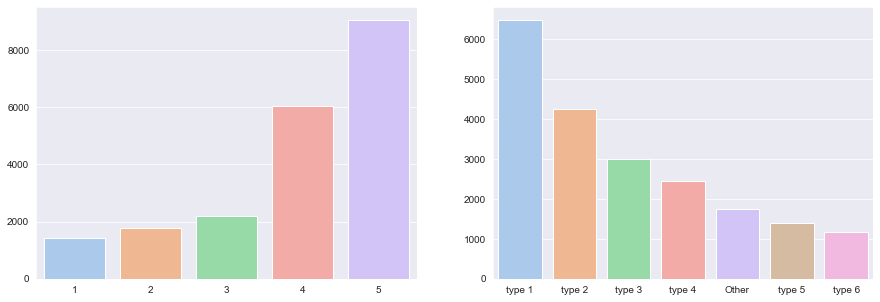

In [28]:
import matplotlib.pyplot as plt

rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])


In [29]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [30]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

Text   Topic Rating  \
0  nice hotel expensive parking got good deal sta...  type 1      4   
1  ok nothing special charge diamond member hilto...   Other      2   
2  nice rooms not 4* experience hotel monaco seat...  type 1      3   
3  unique, great stay, wonderful time hotel monac...  type 1      5   
4  great stay great stay, went seahawk game aweso...  type 2      5   

                                          Lemma-text  len  
0  [parking, deal, anniversary, evening, review, ...   87  
1  [charge, decide, chain, shoot, anniversary, pa...  250  
2  [experience, level, positive, bathroom, bed, h...  217  
3  [stroll, downtown, shopping, area, sign, anima...   89  
4  [seahawk, game, building, complain, website, s...  191

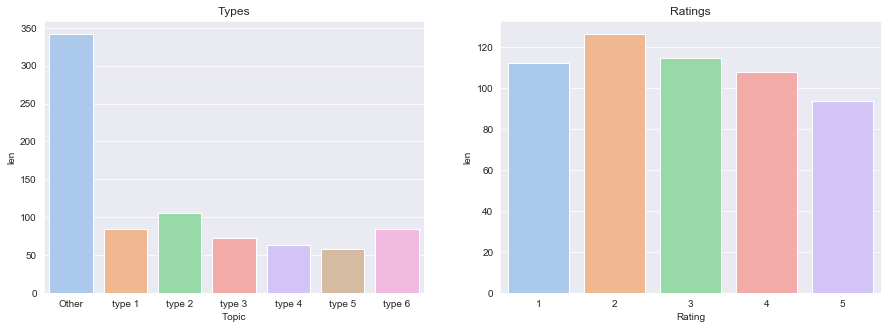

In [31]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

In [32]:
result.Rating = pd.to_numeric(result.Rating)

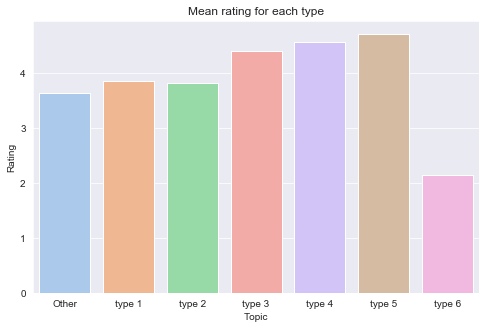

In [33]:
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

In [34]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [35]:
result = result.drop('Lemma-text', axis=1)

In [36]:
from wordcloud import WordCloud 

In [37]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

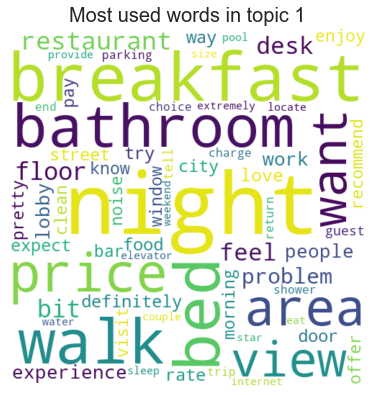

In [38]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

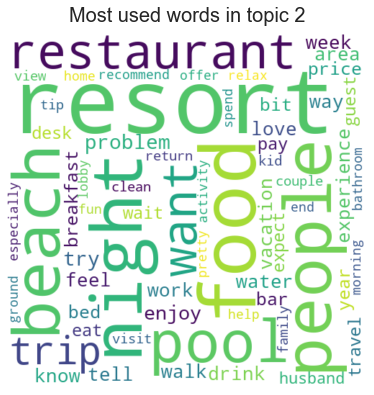

In [39]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

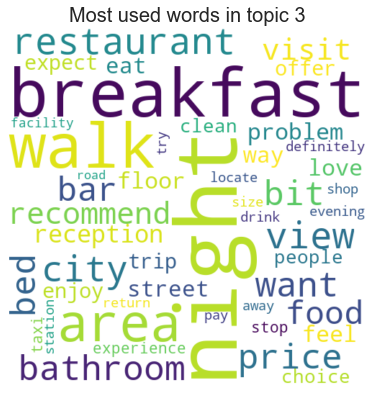

In [40]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

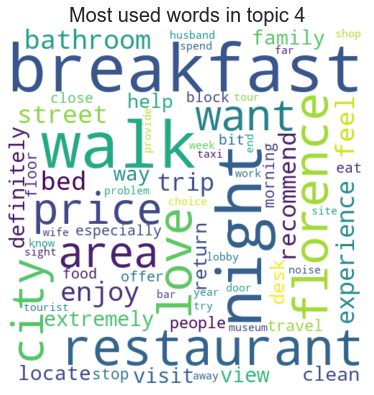

In [41]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

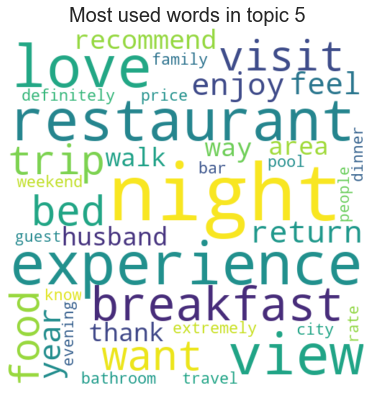

In [42]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

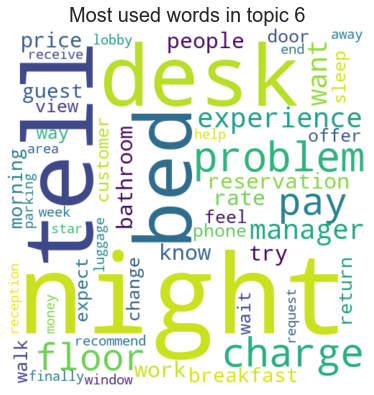

In [43]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

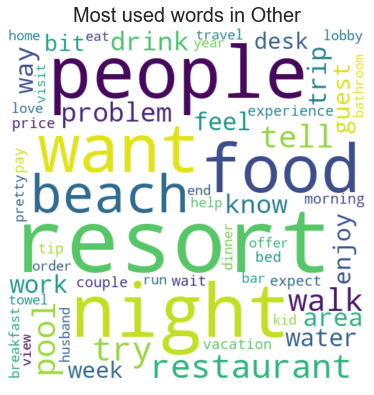

In [44]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

In [45]:
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [47]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

model created
0.32128286071947987
model created
0.3223816139428061
model created
0.32110456880266375
model created
0.3178407569855661
model created
0.31924883116531105


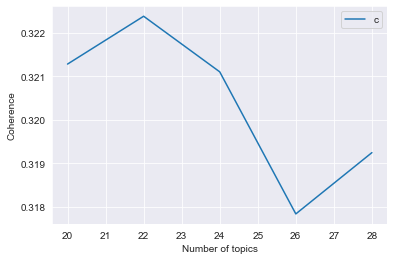

In [48]:
import matplotlib.pyplot as plt
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(5,
  '0.003*"breakfast" + 0.002*"night" + 0.002*"love" + 0.002*"restaurant" + 0.002*"walk" + 0.002*"return" + 0.002*"feel" + 0.002*"pool" + 0.002*"food" + 0.002*"area"'),
 (1,
  '0.003*"night" + 0.003*"food" + 0.003*"price" + 0.003*"restaurant" + 0.003*"walk" + 0.003*"bed" + 0.002*"breakfast" + 0.002*"want" + 0.002*"area" + 0.002*"bathroom"'),
 (20,
  '0.003*"night" + 0.003*"bed" + 0.002*"price" + 0.002*"view" + 0.002*"bathroom" + 0.002*"breakfast" + 0.002*"area" + 0.002*"experience" + 0.002*"love" + 0.002*"recommend"'),
 (9,
  '0.003*"breakfast" + 0.002*"night" + 0.002*"area" + 0.002*"walk" + 0.002*"bed" + 0.002*"restaurant" + 0.002*"bathroom" + 0.002*"definitely" + 0.002*"recommend" + 0.002*"resort"'),
 (8,
  '0.003*"view" + 0.003*"night" + 0.003*"breakfast" + 0.002*"restaurant" + 0.002*"bed" + 0.002*"walk" + 0.002*"floor" + 0.002*"want" + 0.002*"beach" + 0.002*"area"'),
 (4,
  '0.003*"night" + 0.002*"price" + 0.002*"restaurant" + 0.002*"area" + 0.002*"view" + 0.002*"walk" + 0.002*

In [62]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

C:\Users\49173\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\49173\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\49173\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning:

`np.bool`

BrokenProcessPool: A result has failed to un-serialize. Please ensure that the objects returned by the function are always picklable.

In [55]:
from pyLDAvis import gensim

ImportError: cannot import name 'gensim' from 'pyLDAvis' (C:\Users\49173\Anaconda3\lib\site-packages\pyLDAvis\__init__.py)

In [63]:
from gensim.models import LsiModel

In [64]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)

model created
0.4227766515211074
model created
0.4150915578014293
model created
0.3779233524770294
model created
0.37512269103138485
model created
0.3706258705889042
model created
0.35810381393838614
model created
0.3479430894537929
model created
0.35572137587803354
model created
0.33598279440669354
model created
0.34171424111197113
model created
0.33503421646654385
model created
0.32613451387584086
model created
0.3246870317980672
model created
0.32258331132626683


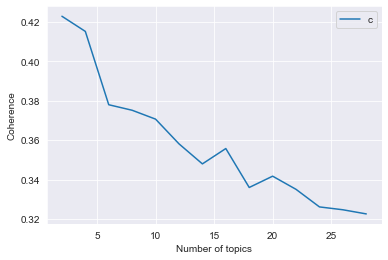

In [65]:
limit, start, step = 30, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

[(0,
  '0.174*"resort" + 0.138*"night" + 0.136*"food" + 0.135*"pool" + 0.134*"restaurant" + 0.124*"beach" + 0.123*"walk" + 0.120*"breakfast" + 0.117*"people" + 0.116*"area"'),
 (1,
  '-0.501*"resort" + -0.260*"beach" + -0.183*"pool" + -0.177*"food" + 0.164*"breakfast" + -0.159*"vacation" + 0.139*"city" + 0.130*"bathroom" + 0.124*"view" + 0.121*"walk"')]